In [2]:
from IPython.core.display import HTML
HTML("<style>.container { width:90% !important; }</style>")

In [4]:
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
# plt.style.use('ggplot')

dirName = "/Users/mfisherlevine/Desktop/CBP_talk_plots"

import matplotlib
matplotlib.rcParams['axes.formatter.useoffset'] = False
from scipy import interpolate


In [22]:
# pixel coordinates
ib = np.linspace(-1, 1, 5000)

# true per-pixel sensitivity variation (assuming all pixels are the same size)
nPerCCD = len(ib)//4      # we have 4 chips in the following S_qe prescription
S_qe = 0.98*np.where(ib < -0.5,         0.90 - 0.1*(ib + 0.5), 
                     np.where(ib < 0,   0.95 + 0.05*ib,
                     np.where(ib < 0.5, 0.85 - 0.1*(ib - 0.5), 
                                        0.87 + 0.05*ib)))

PLOT = False


ghost_phase = 0.
ghost_freq = 2.
nSampleCBP = 15            # number of CBP spots per chip

max_errors = []

for ghost_phase in range(0,6283):
    ghost_phase /= 1000.
    
    i = 0.05*ib**2
    A = -0.07*np.cos(ghost_freq*ib*np.pi+ghost_phase)
    S_optical = 1 + 0.1*ib**4
    S_ccd = 1 + 0.01*np.sin(50*ib*np.pi) 
    calS = S_qe*S_optical*S_ccd
    Fb = (1 + i + A)*calS
    samples = (np.arange(len(ib))%nPerCCD)%(nPerCCD//nSampleCBP) == (nPerCCD//nSampleCBP)//2  # Where we take CBP data
    interpCalS = interpolate.InterpolatedUnivariateSpline(ib[samples], calS[samples], k=3)  # spline fit to CBP data
    rawEstIllum = Fb/interpCalS(ib)   # raw estimated illumination
    interpIllum = interpolate.UnivariateSpline(ib[samples], rawEstIllum[samples], s=1e-8)
    estCalS = Fb/interpIllum(ib)
    maxval = np.max(estCalS/calS)
    max_errors.append((ghost_phase, maxval))

    if PLOT:
        plt.figure(figsize=(12,8))
        plt.plot(ib, Fb, label='$Flat\endash field \ screen$')

        plt.plot(ib[samples], calS[samples], 'o', label=r'$CBP \ points$')
        plt.plot(ib, interpCalS(ib), label=r'$Spline \ fit \ to \ CBP$')

        plt.plot(ib, rawEstIllum, label='$Estimated \ illumination \ correction$')
        plt.plot(ib, interpIllum(ib), label='$Smoothed \ \ illumination \ correction$')

        plt.plot(ib, calS + 0.3)
        plt.plot(ib, estCalS + 0.3, label=r'$0.3 + ({\cal F}_b/fit({\cal F}_b/fit(CBP_b)) \equiv \tilde{\cal S}_b)$')

        plt.legend(loc='best',  fontsize=20, ncol=2)
        foo = plt.ylim(0.5, 1.35)

        plt.figure(figsize=(12,8))
        ax = plt.subplot(111)
        plt.plot(ib, (estCalS/calS), label=r'$\tilde{\cal F}_b/{\cal F}_s$')
        plt.axhline(1.0, color='k', ls='--')
        plt.axhline(maxval, color='r', ls=':')

        _ = plt.title(r'Flat-field illumination correction residuals')
        ticks = list(ax.get_yticks())#.append(maxval)
        ticks = [np.round(_,4) for _ in ax.get_yticks()]
        ticks.append(np.round(maxval,5))
        ax.set_yticks(ticks)
        plt.ylim(0.998,1.0005)
        plt.legend(loc='best',  fontsize=30)
        plt.savefig(os.path.join(dirName, "CBP-errors_%s_points.png"%nSampleCBP))



[ 0.          1.00003052]


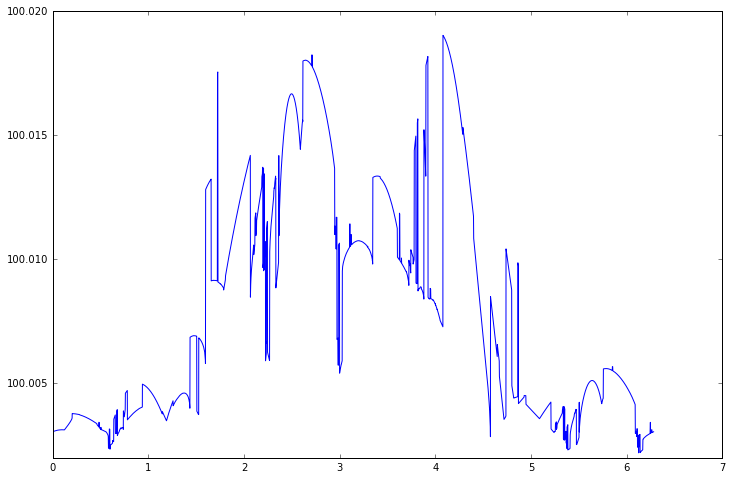

In [23]:
max_errors = np.asarray(max_errors)
fig = plt.figure(figsize=(12,8))
plt.plot(max_errors[:,0], 100*(max_errors[:,1]),'-')
print max_errors[0]

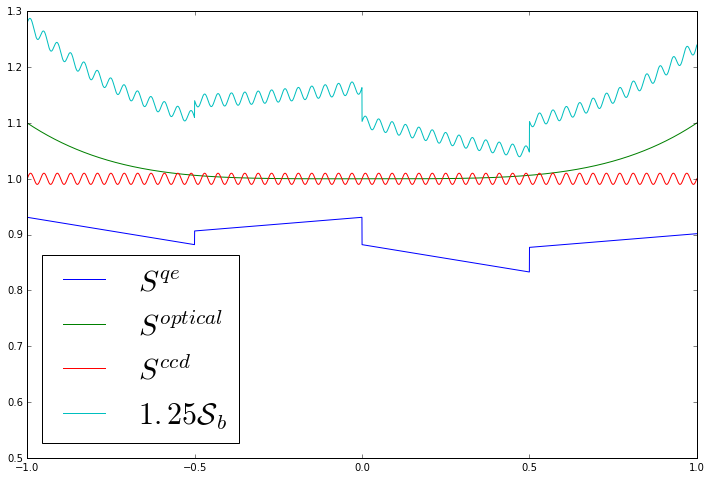

In [62]:
# plt.figure(figsize=(12,8))
# plt.plot(ib, S_qe, label='$S^{qe}$')
# plt.plot(ib, S_optical, label='$S^{optical}$')
# plt.plot(ib, S_ccd, label='$S^{ccd}$')

# # plt.plot(ib, 1.3*Fb, label='$Fb$')

# scale=1.25
# plt.plot(ib, scale*calS, label='$%g{\cal S}_b$' % scale)

# plt.legend(loc='best', fontsize=30).draggable()
# foo = plt.ylim(0.5, 1.3)

# plt.savefig(os.path.join(dirName, "S.pdf"))

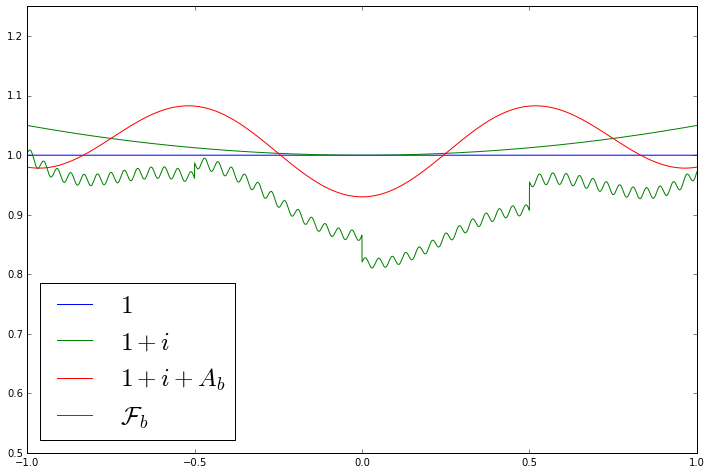

In [63]:
# plt.figure(figsize=(12,8))

# plt.plot(ib, np.ones_like(ib), label='$1$')
# plt.plot(ib, 1 + i, label='$1 + i$')
# # plt.plot(ib, 1 + A, label='$1 + A$')
# plt.plot(ib, 1 + i + A, label='$1 + i + A_b$')
# if False:
#     scale = 1.3
#     plt.plot(ib, scale*calS, label='$%g{\cal S}_b$' % scale)

# plt.plot(ib, Fb, 'g-', label='${\cal F}_b$')

# plt.legend(loc='best', fontsize=25).draggable()
# foo = plt.ylim(0.5, 1.25)

# plt.savefig(os.path.join(dirName, "F_b.png"))

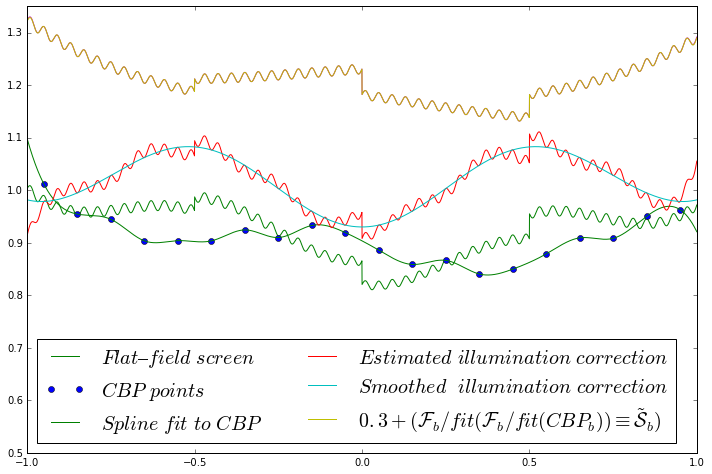

In [64]:
# from scipy import interpolate

# nSampleCBP = 5            # number of CBP spots per chip

# # true/false array of which points are sampled in CCD space
# samples = (np.arange(len(ib))%nPerCCD)%(nPerCCD//nSampleCBP) == (nPerCCD//nSampleCBP)//2  # Where we take CBP data

# interpCalS = interpolate.InterpolatedUnivariateSpline(ib[samples], calS[samples], k=3)  # spline fit to CBP data
# #
# # Estimate the illumination from the interpolated CBP data
# rawEstIllum = Fb/interpCalS(ib)   # raw estimated illumination
# # And fit it with a smoothing spline
# interpIllum = interpolate.UnivariateSpline(ib[samples], rawEstIllum[samples], s=1e-8)
# # and use that to estimate the true calS
# estCalS = Fb/interpIllum(ib)

# plt.figure(figsize=(12,8))
# plt.plot(ib, Fb, 'g-',  label='$Flat\endash field \ screen$')

# plt.plot(ib[samples], calS[samples], 'o', label=r'$CBP \ points$')
# plt.plot(ib, interpCalS(ib), label=r'$Spline \ fit \ to \ CBP$')

# plt.plot(ib, rawEstIllum, label='$Estimated \ illumination \ correction$')
# plt.plot(ib, interpIllum(ib), label='$Smoothed \ \ illumination \ correction$')

# plt.plot(ib, calS + 0.3)
# plt.plot(ib, estCalS + 0.3, label=r'$0.3 + ({\cal F}_b/fit({\cal F}_b/fit(CBP_b)) \equiv \tilde{\cal S}_b)$')

# plt.legend(loc='best',  fontsize=20, ncol=2)
# foo = plt.ylim(0.5, 1.35)

# plt.savefig(os.path.join(dirName, "CBP.pdf"))

In [65]:
print nSampleCBP

5


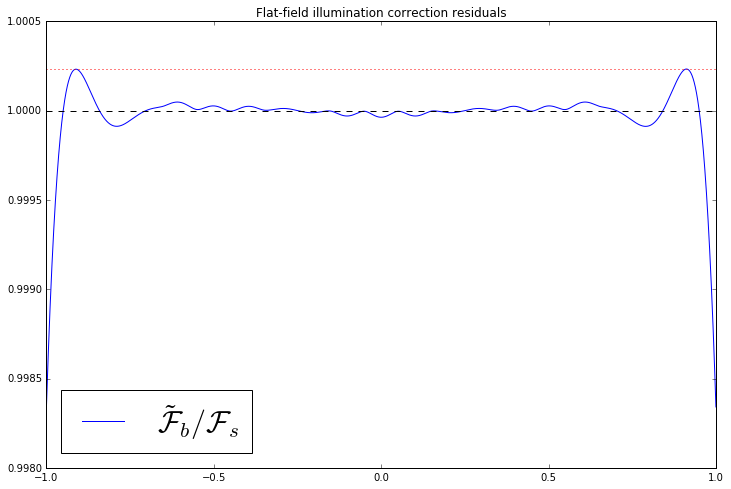

In [66]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111)
plt.plot(ib, (estCalS/calS), label=r'$\tilde{\cal F}_b/{\cal F}_s$')
plt.axhline(1.0, color='k', ls='--')
maxval = np.max(estCalS/calS)
plt.axhline(maxval, color='r', ls=':')

_ = plt.title(r'Flat-field illumination correction residuals')
# ticks = list(ax.get_yticks())#.append(maxval)
# ticks = [np.round(_,4) for _ in ax.get_yticks()]
# ticks.append(np.round(maxval,5))
# ax.set_yticks(ticks)
# plt.ylim(0.998,1.0005)
plt.legend(loc='best',  fontsize=30)


plt.savefig(os.path.join(dirName, "CBP-errors.pdf"))

In [ ]:
PLOT = False

max_errors = []
for nSampleCBP in range(1,25):            # number of CBP spots per chip

    # true/false array of which points are sampled in CCD space
    samples = (np.arange(len(ib))%nPerCCD)%(nPerCCD//nSampleCBP) == (nPerCCD//nSampleCBP)//2  # Where we take CBP data

    interpCalS = interpolate.InterpolatedUnivariateSpline(ib[samples], calS[samples], k=3)  # spline fit to CBP data
    #
    # Estimate the illumination from the interpolated CBP data
    rawEstIllum = Fb/interpCalS(ib)   # raw estimated illumination
    # And fit it with a smoothing spline
    interpIllum = interpolate.UnivariateSpline(ib[samples], rawEstIllum[samples], s=1e-8)
    # and use that to estimate the true calS
    estCalS = Fb/interpIllum(ib)

    maxval = np.max(estCalS/calS)

    if PLOT:
        plt.figure(figsize=(12,8))
        plt.plot(ib, Fb, label='$Flat\endash field \ screen$')

        plt.plot(ib[samples], calS[samples], 'o', label=r'$CBP \ points$')
        plt.plot(ib, interpCalS(ib), label=r'$Spline \ fit \ to \ CBP$')

        plt.plot(ib, rawEstIllum, label='$Estimated \ illumination \ correction$')
        plt.plot(ib, interpIllum(ib), label='$Smoothed \ \ illumination \ correction$')

        plt.plot(ib, calS + 0.3)
        plt.plot(ib, estCalS + 0.3, label=r'$0.3 + ({\cal F}_b/fit({\cal F}_b/fit(CBP_b)) \equiv \tilde{\cal S}_b)$')

        plt.legend(loc='best',  fontsize=20, ncol=2)
        foo = plt.ylim(0.5, 1.35)

        plt.figure(figsize=(12,8))
        ax = plt.subplot(111)
        plt.plot(ib, (estCalS/calS), label=r'$\tilde{\cal F}_b/{\cal F}_s$')
        plt.axhline(1.0, color='k', ls='--')
        plt.axhline(maxval, color='r', ls=':')

        _ = plt.title(r'Flat-field illumination correction residuals')
        ticks = list(ax.get_yticks())#.append(maxval)
        ticks = [np.round(_,4) for _ in ax.get_yticks()]
        ticks.append(np.round(maxval,5))
        ax.set_yticks(ticks)
        plt.ylim(0.998,1.0005)
        plt.legend(loc='best',  fontsize=30)
        plt.savefig(os.path.join(dirName, "CBP-errors_%s_points.png"%nSampleCBP))
    
    max_errors.append((nSampleCBP, maxval))

In [ ]:
max_errors = np.asarray(max_errors)
n_skip = 2
fig = plt.figure(figsize=(12,8))
plt.plot(max_errors[:,0][n_skip:], 100*(max_errors[:,1][n_skip:]-1),'o')

In [ ]:
print max_errors[4]